In [ ]:
import numpy as np 
import pandas as pd 
import os

# training_norm 
df_training_norm = pd.read_csv("/kaggle/input/machine-learning-in-science-ii-2025/training_norm.csv")
df_training_norm.head()

,image_id,angle,speed
0,1,0.4375,0.0
1,2,0.8125,1.0
2,3,0.4375,1.0
3,4,0.6250,1.0
4,5,0.5000,0.0


In [ ]:
import tensorflow as tf
# Prepare the Dataset
df_training_norm["image_path"] = df_training_norm["image_id"].astype(str) + ".png"

# angle, speed 
angle_values = df_training_norm["angle"].values.astype("float32")
speed_values = df_training_norm["speed"].values.astype("float32")  # 0/1
image_paths = df_training_norm["image_path"].values  # เช่น ["1.png", "2.png", ...]

# สร้าง tf.data.Dataset จาก (image_path, angle, speed)
dataset = tf.data.Dataset.from_tensor_slices((image_paths, angle_values, speed_values))

# แบ่งข้อมูลเป็น 3 ส่วน: Train, Validation, Test
total_samples = len(df_training_norm)
train_ratio = 0.7
val_ratio = 0.15

train_size = int(train_ratio * total_samples)
val_size = int(val_ratio * total_samples)

# สร้าง Dataset พื้นฐาน + สุ่มให้กระจาย
full_dataset = tf.data.Dataset.from_tensor_slices((image_paths, angle_values, speed_values))
full_dataset = full_dataset.shuffle(buffer_size=total_samples, seed=42, reshuffle_each_iteration=False)

# แบ่งเป็น Train / Val / Test
train_dataset = full_dataset.take(train_size)
remaining_dataset = full_dataset.skip(train_size)
val_dataset = remaining_dataset.take(val_size)
test_dataset = remaining_dataset.skip(val_size)

# อ่านไฟล์รูป + resize + normalize
def parse_image(image_path, angle, speed):
    image_folder = "/kaggle/input/machine-learning-in-science-ii-2025/training_data/training_data"
    path = tf.strings.join([image_folder, "/", image_path])
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = img / 255.0

    # Multi-output 
    return img, {"angle_output": angle, "speed_output": speed}

# batch_size
batch_size = 32

# pipeline ของ Train/Val/Test แยกกัน
# -- Train: map -> shuffle -> repeat -> batch -> prefetch
train_dataset = (
    train_dataset
    .map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
    .shuffle(500)             # สุ่มภายใน batch อีกชั้น (buffer_size แล้วแต่ต้องการ)
    #.repeat()                 # วนซ้ำไม่สิ้นสุด ให้หยุดตาม epochs แทน
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

# -- Validation: map -> batch -> prefetch (ไม่ต้อง shuffle, ไม่ repeat)
val_dataset = (
    val_dataset
    .map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

# -- Test: map -> batch -> prefetch (ไม่ต้อง shuffle, ไม่ repeat)
test_dataset = (
    test_dataset
    .map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

# Split ก่อน แล้วค่อย Shuffle + Repeat เฉพาะ train

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.applications import ResNet152V2

# ฟังก์ชัน loss แบบ RMSE 
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
# Build the EfficientNetB5 Model with Fine-Tuning
base_model = ResNet152V2(
    weights="imagenet",     # ใช้ pre-trained weights จาก ImageNet
    include_top=False,      # ตัดส่วน fully-connected ด้านบนออก
    input_shape=(224,224,3)
)

# Freeze all layers of the base model so they won't be trained initially
for layer in base_model.layers:
    layer.trainable = False  # ล็อกไม่ให้ train ในเบื้องต้น

# Add custom layers on top of the base model
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)

# หัวแรก angle (Regression)
angle_output = layers.Dense(1, name="angle_output")(x)  # ไม่มี activation หรือใช้ linear ก็ได้

# หัวสอง speed (Binary Classification)
speed_output = layers.Dense(1, activation="sigmoid", name="speed_output")(x)

# multi-output
model = models.Model(
    inputs=base_model.input,
    outputs=[angle_output, speed_output]
)


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss={
        "angle_output": rmse,
        "speed_output": "binary_crossentropy"
    },
    metrics={
        "angle_output": [rmse],         # metric สำหรับ angle
        "speed_output": ["accuracy"]    # metric สำหรับ speed
    },
    loss_weights={
        "angle_output": 1.0,
        "speed_output": 1.0
    }
)

 # model.summary()

234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [4]:
initial_epochs = 20
history_initial = model.fit(
    train_dataset,
    #steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    epochs=initial_epochs
)

Epoch 1/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 89s 205ms/step - angle_output_loss: 0.4398 - angle_output_rmse: 0.4775 - loss: 0.6300 - speed_output_accuracy: 0.9279 - speed_output_loss: 0.1902 - val_angle_output_loss: 0.1222 - val_angle_output_rmse: 0.1952 - val_loss: 0.2141 - val_speed_output_accuracy: 0.9613 - val_speed_output_loss: 0.0916
Epoch 2/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 40s 130ms/step - angle_output_loss: 0.1496 - angle_output_rmse: 0.2209 - loss: 0.2429 - speed_output_accuracy: 0.9646 - speed_output_loss: 0.0933 - val_angle_output_loss: 0.1021 - val_angle_output_rmse: 0.1834 - val_loss: 0.1867 - val_speed_output_accuracy: 0.9666 - val_speed_output_loss: 0.0843
Epoch 3/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 40s 130ms/step - angle_output_loss: 0.1294 - angle_output_rmse: 0.2074 - loss: 0.2051 - speed_output_accuracy: 0.9735 - speed_output_loss: 0.0756 - val_angle_output_loss: 0.1021 - val_angle_output_rmse: 0.1873 - val_loss: 0.1737 - val_speed_output_accuracy: 0.9691 - val_speed_output_lo

In [ ]:
# Gradual Unfreezing
# ปลด freeze เลเยอร์บนสุดของ base model (ปลด 50 เลเยอร์สุดท้าย)
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
for layer in base_model.layers[-50:]:
    layer.trainable = True

# re-compile ด้วย learning rate ที่ต่ำลง
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss={
        "angle_output": rmse,
        "speed_output": "binary_crossentropy"
    },
    metrics={
        "angle_output": [rmse],
        "speed_output": ["accuracy"]
    },
    loss_weights={
        "angle_output": 1.0,
        "speed_output": 1.0
    }
)

# Fine-tune โมเดล (train ต่อจาก initial_epochs) ใช้ ReduceLROnPlateau callback เพื่อติดตามค่า validation loss และลด learning rate เมื่อ performance ไม่ดีขึ้น
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

# สร้าง callback ReduceLROnPlateau --> Callback ลด LR อัตโนมัติเมื่อ val_loss ไม่ดีขึ้น
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    #factor=0.5,    # ลด learning rate ลงครึ่งหนึ่ง สูงเกินไป 
    factor=0.8,
    patience=3,    # ถ้า val_loss ไม่ดีขึ้น 3 epochs ก็ลด
    verbose=1
)

# สร้าง callback สำหรับเซฟเฉพาะตอนที่ val_loss ดีที่สุด
checkpoint = ModelCheckpoint(
    filepath='best_model.weights.h5',   # ชื่อไฟล์สำหรับเซฟ
    monitor='val_loss',         # ตัวชี้วัดที่จะ monitor
    save_best_only=True,        # เซฟเฉพาะตอนที่ค่าดีขึ้น
    mode='min',                 # ถ้าเป็น loss ใช้ 'min'
    save_weights_only=True,     # เลือกว่าจะเซฟเป็น “เฉพาะ weights” หรือเซฟโมเดลเต็ม
    verbose=1
)

history_fine = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=total_epochs,
    initial_epoch=history_initial.epoch[-1],
    callbacks=[lr_reducer, checkpoint]  # <-- ใส่ทั้ง ReduceLROnPlateau และ ModelCheckpoint
)

Epoch 20/30
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - angle_output_loss: 0.1274 - angle_output_rmse: 0.1951 - loss: 0.2830 - speed_output_accuracy: 0.9604 - speed_output_loss: 0.1557
Epoch 20: val_loss improved from inf to 0.21748, saving model to best_model.weights.h5
302/302 ━━━━━━━━━━━━━━━━━━━━ 103s 230ms/step - angle_output_loss: 0.1273 - angle_output_rmse: 0.1951 - loss: 0.2828 - speed_output_accuracy: 0.9605 - speed_output_loss: 0.1555 - val_angle_output_loss: 0.0962 - val_angle_output_rmse: 0.2094 - val_loss: 0.2175 - val_speed_output_accuracy: 0.9821 - val_speed_output_loss: 0.1209 - learning_rate: 5.0000e-04
Epoch 21/30
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - angle_output_loss: 0.1010 - angle_output_rmse: 0.2010 - loss: 0.1528 - speed_output_accuracy: 0.9837 - speed_output_loss: 0.0518
Epoch 21: val_loss improved from 0.21748 to 0.16150, saving model to best_model.weights.h5
302/302 ━━━━━━━━━━━━━━━━━━━━ 49s 161ms/step - angle_output_loss: 0.1010 - angle_output_rmse: 0.

In [ ]:
test_results = model.evaluate(test_dataset)
print("Test results:", test_results)

65/65 ━━━━━━━━━━━━━━━━━━━━ 12s 179ms/step - angle_output_loss: 0.0717 - angle_output_rmse: 0.2101 - loss: 0.1014 - speed_output_accuracy: 0.9955 - speed_output_loss: 0.0297
Test results: [0.11619886755943298, 0.07206689566373825, 0.04431832581758499, 0.20456664264202118, 0.991304337978363]


In [ ]:
# โหลด weights ที่ดีที่สุด
model.load_weights("best_model.weights.h5")

# เซฟโมเดลเต็ม (architecture + weights + compile config) ลงไฟล์ .h5
model.save("my_full_model.h5")

print("Saved full model to my_full_model_10/03.h5")

Saved full model to my_full_model_10/03.h5


In [ ]:
# predict model
from tensorflow.keras.models import load_model
from tensorflow.keras import losses
import tensorflow as tf
#from tensorflow.keras.losses import MeanSquaredError

loaded_model = load_model("/kaggle/working/my_full_model.h5", custom_objects={'rmse': rmse})
print("Model loaded successfully.")

# Define the test images folder path
test_folder = "/kaggle/input/machine-learning-in-science-ii-2025/test_data/test_data"

test_image_files = sorted(
    [f for f in os.listdir(test_folder) if f.endswith(".png")],
    key=lambda x: int(x.split(".")[0])  # แปลงชื่อไฟล์เป็นตัวเลขก่อนเรียง
)

# Create a tf.data.Dataset from the list of image files
test_dataset = tf.data.Dataset.from_tensor_slices(test_image_files)

# Define a function to load and preprocess each test image
def load_test_image(image_file):
    image_path = tf.strings.join([test_folder, "/", image_file])
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = img / 255.0
    return img

# Map the function to the dataset, then batch and prefetch the data
test_dataset = test_dataset.map(load_test_image, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Generate predictions using the trained model
predictions = loaded_model.predict(test_dataset)
print(type(predictions))
print(len(predictions))
print(predictions[0].shape)

pred_angle = predictions[0]
pred_speed = predictions[1]
pred_angle = pred_angle.flatten()
pred_speed = pred_speed.flatten()

# 6) Create a DataFrame to store the prediction results
# Using the image file names as identifiers
test_df = pd.DataFrame({
    "image_id": range(1, len(test_image_files) + 1),
    "angle": pred_angle,
    "speed": pred_speed
})


# 7) Save the results to 'submission.csv' in the working directory
test_df.to_csv('/kaggle/working/submission_ResNet152V2_Multi-Output+Gradual_Unfreezing+LearningRate_Scheduler.csv', index=False)

# 8) Verify that the 'submission.csv' file has been created by listing files in the current directory
print("Files in the current directory:")
print(os.listdir('.'))

Model loaded successfully.
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 357ms/step
<class 'list'>
2
(1020, 1)
Files in the current directory:
['best_model.weights.h5', 'submission_ResNet152V2_Multi-Output+Gradual_Unfreezing+LearningRate_Scheduler.csv', 'my_full_model.h5', '.virtual_documents']


Available history keys: dict_keys(['angle_output_loss', 'angle_output_rmse', 'loss', 'speed_output_accuracy', 'speed_output_loss', 'val_angle_output_loss', 'val_angle_output_rmse', 'val_loss', 'val_speed_output_accuracy', 'val_speed_output_loss', 'learning_rate'])


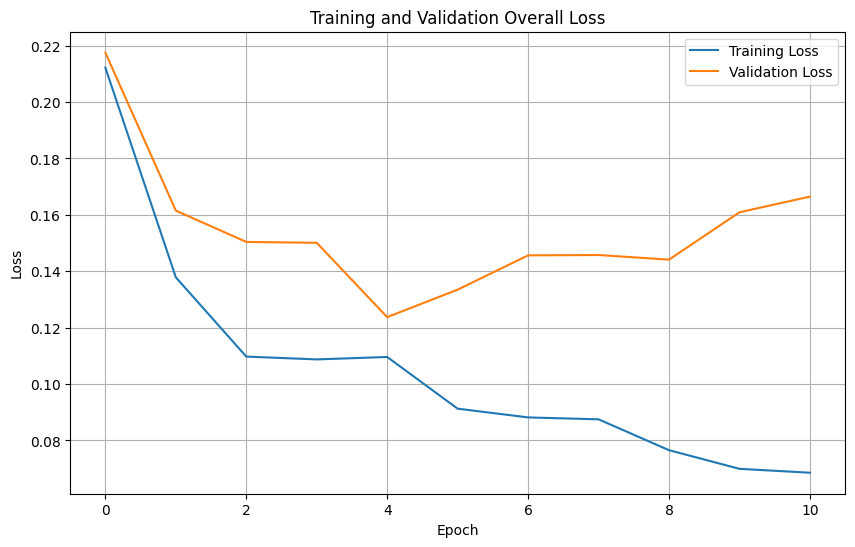

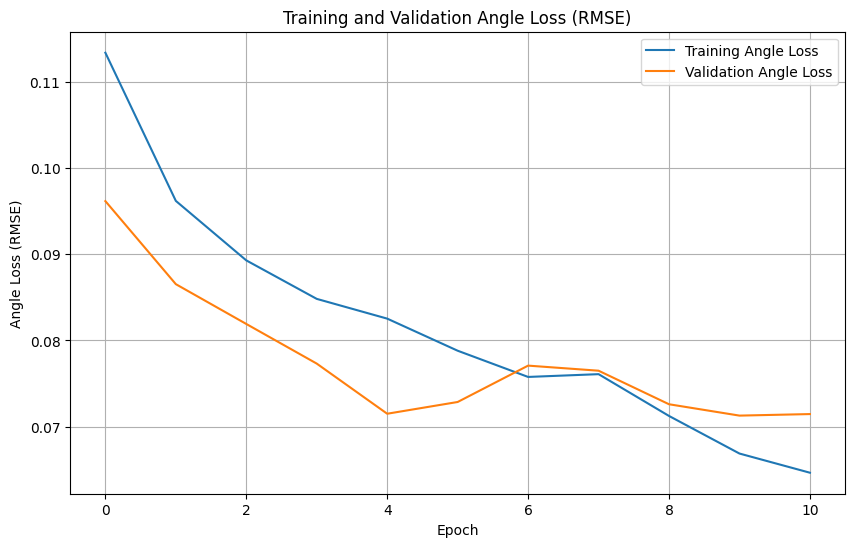

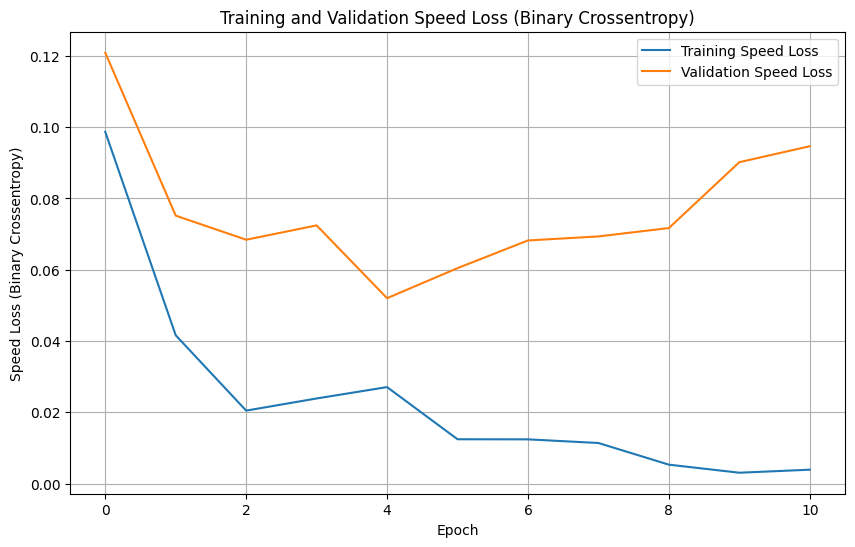

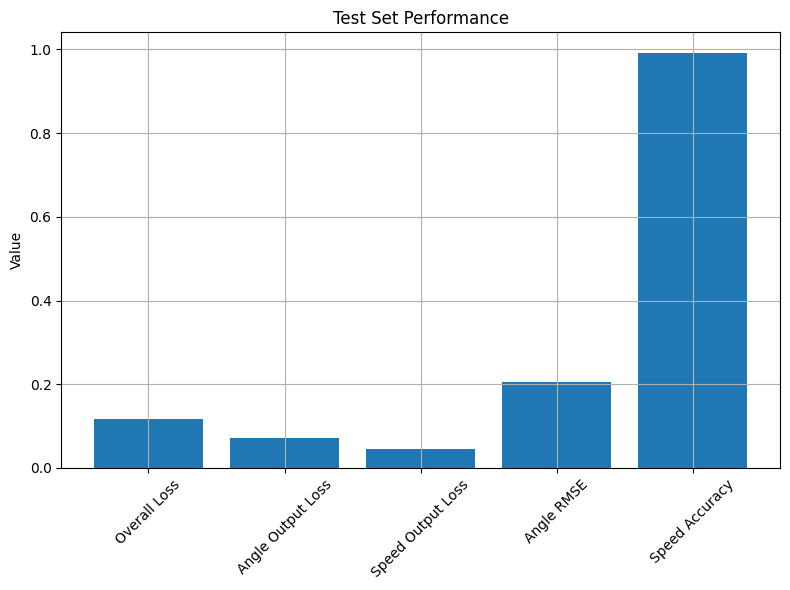

In [10]:
import matplotlib.pyplot as plt

# Debug: Print available history keys to see what metrics are recorded
print("Available history keys:", history_fine.history.keys())

# Plot Overall Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history_fine.history['loss'], label='Training Loss')
if 'val_loss' in history_fine.history:
    plt.plot(history_fine.history['val_loss'], label='Validation Loss')
else:
    print("No validation loss found in history.")

plt.title('Training and Validation Overall Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig("/kaggle/working/training_validation_loss_EfficientNetB5_final.png")
plt.show()

# Optionally: Plot Loss for each output separately

# Plot for angle_output (Regression Loss: RMSE)
if 'angle_output_loss' in history_fine.history and 'val_angle_output_loss' in history_fine.history:
    plt.figure(figsize=(10, 6))
    plt.plot(history_fine.history['angle_output_loss'], label='Training Angle Loss')
    plt.plot(history_fine.history['val_angle_output_loss'], label='Validation Angle Loss')
    plt.title('Training and Validation Angle Loss (RMSE)')
    plt.xlabel('Epoch')
    plt.ylabel('Angle Loss (RMSE)')
    plt.legend()
    plt.grid(True)
    plt.savefig("/kaggle/working/training_validation_angle_loss.png")
    plt.show()

# Plot for speed_output (Classification Loss: Binary Crossentropy)
if 'speed_output_loss' in history_fine.history and 'val_speed_output_loss' in history_fine.history:
    plt.figure(figsize=(10, 6))
    plt.plot(history_fine.history['speed_output_loss'], label='Training Speed Loss')
    plt.plot(history_fine.history['val_speed_output_loss'], label='Validation Speed Loss')
    plt.title('Training and Validation Speed Loss (Binary Crossentropy)')
    plt.xlabel('Epoch')
    plt.ylabel('Speed Loss (Binary Crossentropy)')
    plt.legend()
    plt.grid(True)
    plt.savefig("/kaggle/working/training_validation_speed_loss.png")
    plt.show()

# Plot Bar Chart แสดงค่าจาก test set
test_keys = [
    'Overall Loss',
    'Angle Output Loss',
    'Speed Output Loss',
    'Angle RMSE',
    'Speed Accuracy'
]
plt.figure(figsize=(8, 6))
plt.bar(test_keys, test_results)
plt.title("Test Set Performance")
plt.ylabel("Value")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig("/kaggle/working/test_set_performance_bar.png")
plt.show()


In [11]:
import pandas as pd
submission = pd.read_csv("/kaggle/working/submission_ResNet152V2_Multi-Output+Gradual_Unfreezing+LearningRate_Scheduler.csv")
submission.head()

,image_id,angle,speed
0,1,0.526385,1.577363e-07
1,2,0.754485,1.000000e+00
2,3,0.180528,9.998170e-01
3,4,0.238506,9.999999e-01
4,5,0.227158,9.999999e-01


In [12]:
submission = pd.read_csv("/kaggle/working/submission_ResNet152V2_Multi-Output+Gradual_Unfreezing+LearningRate_Scheduler.csv")
df = pd.read_csv("/kaggle/input/machine-learning-in-science-ii-2025/training_norm.csv")

# สร้างลิสต์ของค่าที่เป็นไปได้ (unique)
possible_angles = list(set(df['angle'].tolist()))
# possible_speeds = [1, 0]
possible_speeds = list(set(df['speed'].tolist()))

# ฟังก์ชันหา "ค่าที่ใกล้ที่สุด" (naive method)
def find_closest_value(x, candidate_list):
    return min(candidate_list, key=lambda val: abs(val - x))

# ปรับค่าของ angle และ speed
submission['angle'] = submission['angle'].apply(
    lambda x: find_closest_value(x, possible_angles)
)
submission['speed'] = submission['speed'].apply(
    lambda x: find_closest_value(x, possible_speeds)
).astype(int)

submission.to_csv("/kaggle/working/submission_final.csv", index=False)

In [13]:
df_submission = pd.read_csv("/kaggle/working/submission_final.csv")
df_submission

,image_id,angle,speed
0,1,0.5000,0
1,2,0.7500,1
2,3,0.1875,1
3,4,0.2500,1
4,5,0.2500,1
...,...,...,...
1015,1016,0.5000,1
1016,1017,0.6875,0
1017,1018,0.4375,1
1018,1019,0.2500,1
